# Bayesian Neural Networks

In this tutorial, we demonstrate how one can implement a Bayesian Neural Network using a combination of Turing and [Flux](https://github.com/FluxML/Flux.jl), a suite of tools machine learning. We will use Flux to specify the neural network's layers and Turing to implement the probabalistic inference, with the goal of implementing a classification algorithm.

We will begin with importing the relevant libraries.

In [1]:
# Import libraries.
using Turing, Flux, Plots, Random, ReverseDiff

# Hide sampling progress.
Turing.turnprogress(false);

# Use reverse_diff due to the number of parameters in neural networks.
Turing.setadbackend(:reversediff)

┌ Info: [Turing]: progress logging is disabled globally
└ @ Turing /home/theo/.julia/packages/Turing/GMBTf/src/Turing.jl:22


:reversediff

Our goal here is to use a Bayesian neural network to classify points in an artificial dataset. The code below generates data points arranged in a box-like pattern and displays a graph of the dataset we'll be working with.

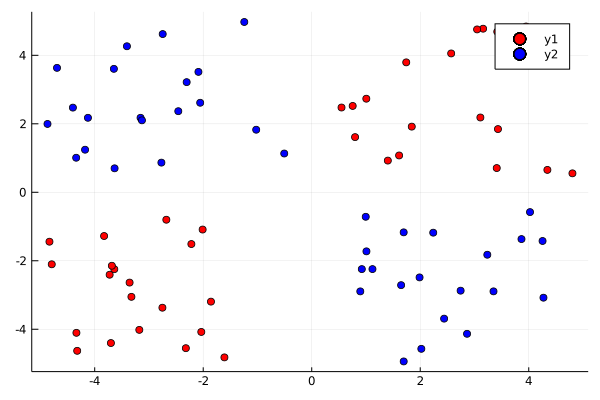

In [2]:
# Number of points to generate.
N = 80
M = round(Int, N / 4)
Random.seed!(1234)

# Generate artificial data.
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; 
xt1s = Array([[x1s[i] + 0.5; x2s[i] + 0.5] for i = 1:M])
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; 
append!(xt1s, Array([[x1s[i] - 5; x2s[i] - 5] for i = 1:M]))

x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; 
xt0s = Array([[x1s[i] + 0.5; x2s[i] - 5] for i = 1:M])
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; 
append!(xt0s, Array([[x1s[i] - 5; x2s[i] + 0.5] for i = 1:M]))

# Store all the data for later.
xs = [xt1s; xt0s]
ts = [ones(2*M); zeros(2*M)]

# Plot data points.
function plot_data()
    x1 = map(e -> e[1], xt1s)
    y1 = map(e -> e[2], xt1s)
    x2 = map(e -> e[1], xt0s)
    y2 = map(e -> e[2], xt0s)

    Plots.scatter(x1,y1, color="red", clim = (0,1))
    Plots.scatter!(x2, y2, color="blue", clim = (0,1))
end

plot_data()

## Building a Neural Network

The next step is to define a [feedforward neural network](https://en.wikipedia.org/wiki/Feedforward_neural_network) where we express our parameters as distribtuions, and not single points as with traditional neural networks. The two functions below, `unpack` and `nn_forward` are helper functions we need when we specify our model in Turing.

`unpack` takes a vector of parameters and partitions them between weights and biases. `nn_forward` constructs a neural network with the variables generated in `unpack` and returns a prediction based on the weights provided.

The `unpack` and `nn_forward` functions are explicity designed to create a neural network with two hidden layers and one output layer, as shown below.

<img width="320" alt="nn-diagram" src="https://user-images.githubusercontent.com/422990/47970321-bd172080-e038-11e8-9c6d-6c2bd790bd8a.png">

The end of this tutorial provides some code that can be used to generate more general network shapes.

In [3]:
# We construct an architecture for our neural network using Flux
nn = Chain(Dense(2, 3, tanh),
            Dense(3, 2, tanh),
            Dense(2, 1, σ))

# We extract a flattened vector of parameters and the reconstruction function
θ, re = Flux.destructure(nn)
n_params = length(θ) # Here we have 20 parameters

# Calling re(θ) will reconstruct the network

function nn_forward(xs, nn_params::AbstractVector)
    nn = re(nn_params)
    return nn(xs)
end;

The probabalistic model specification below creates a `params` variable, which has 20 normally distributed variables. Each entry in the `params` vector represents weights and biases of our neural net.

In [4]:
# Create a regularization term and a Gaussain prior variance term.
alpha = 0.09
sig = sqrt(1.0 / alpha)

# Specify the probabalistic model.
@model bayes_nn(xs, ts) = begin
    # Create the weight and bias vector.
    nn_params ~ MvNormal(zeros(n_params), sig .* ones(n_params))
    
    # Calculate predictions for the inputs given the weights
    # and biases in theta.
    preds = nn_forward(xs, nn_params)
    
    # Observe each prediction.
    for i = 1:length(ts)
        ts[i] ~ Bernoulli(preds[i])
    end
end;

Inference can now be performed by calling `sample`. We use the `HMC` sampler here.

In [5]:
# Perform inference.
N = 5000
ch = sample(bayes_nn(hcat(xs...), ts), HMC(0.05, 4), N);

Now we extract the weights and biases from the sampled chain. We'll use these primarily in determining how good a classifier our model is.

In [6]:
# Extract all weight and bias parameters.
theta = ch[:nn_params].value.data;

## Prediction Visualization

We can use [MAP estimation](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) to classify our population by using the set of weights that provided the highest log posterior.

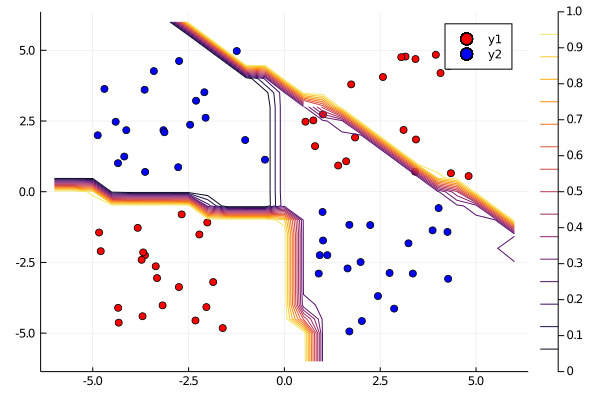

In [7]:
# Plot the data we have.
plot_data()

# Find the index that provided the highest log posterior in the chain.
_, i = findmax(ch[:lp].value.data)

# Extract the max row value from i.
i = i.I[1]

# Plot the posterior distribution with a contour plot.
x_range = collect(range(-6,stop=6,length=25))
y_range = collect(range(-6,stop=6,length=25))
Z = [nn_forward([x, y], theta[i, :])[1] for x=x_range, y=y_range]
contour!(x_range, y_range, Z)

The contour plot above shows that the MAP method is not too bad at classifying our data.

Now we can visualize our predictions.

$$ 
p(\tilde{x} | X, \alpha) = \int_{\theta} p(\tilde{x} | \theta) p(\theta | X, \alpha) \approx \sum_{\theta \sim p(\theta | X, \alpha)}f_{\theta}(\tilde{x}) 
$$

The `nn_predict` function takes the average predicted value from a network parameterized by weights drawn from the MCMC chain.

In [8]:
# Return the average predicted value across
# multiple weights.
function nn_predict(x, theta, num)
    mean([nn_forward(x, theta[i,:])[1] for i in 1:10:num])
end;

Next, we use the `nn_predict` function to predict the value at a sample of points where the `x` and `y` coordinates range between -6 and 6. As we can see below, we still have a satisfactory fit to our data.

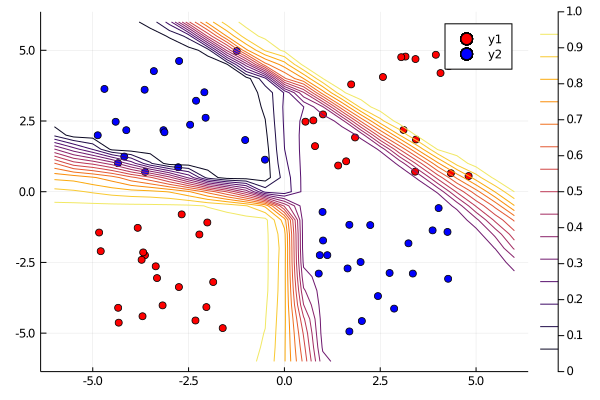

In [9]:
# Plot the average prediction.
plot_data()

n_end = 1500
x_range = collect(range(-6,stop=6,length=25))
y_range = collect(range(-6,stop=6,length=25))
Z = [nn_predict([x, y], theta, n_end)[1] for x=x_range, y=y_range]
contour!(x_range, y_range, Z)

If you are interested in how the predictive power of our Bayesian neural network evolved between samples, the following graph displays an animation of the contour plot generated from the network weights in samples 1 to 1,000. 

┌ Info: Saved animation to 
│   fn = /home/theo/.julia/dev/TuringTutorials/tmp.gif
└ @ Plots /home/theo/.julia/packages/Plots/6RLiv/src/animation.jl:104


Plots.AnimatedGif("/home/theo/.julia/dev/TuringTutorials/tmp.gif")
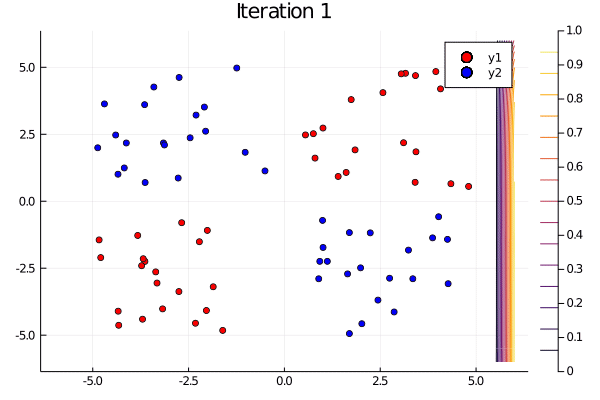

In [10]:
# Number of iterations to plot.
n_end = 500

anim = @gif for i=1:n_end
    plot_data()
    Z = [nn_forward([x, y], theta[i,:])[1] for x=x_range, y=y_range]
    contour!(x_range, y_range, Z, title="Iteration $i", clim = (0,1))
end every 5



## Variational Inference (ADVI)

We can also use Turing's variational inference tools to estimate the parameters of this model. See [variational inference](https://turing.ml/dev/docs/for-developers/variational_inference) for more information.

In [11]:
using Bijectors
using Turing: Variational

m = bayes_nn(hcat(xs...), ts);

q = Variational.meanfield(m)

μ = randn(length(q))
ω = -1 .* ones(length(q))

q = Variational.update(q, μ, exp.(ω));

advi = ADVI(10, 1000)
q_hat = vi(m, advi, q);

┌ Info: [ADVI] Should only be seen once: optimizer created for θ
│   objectid(θ) = 4859741564866774727
└ @ Turing.Variational /home/theo/.julia/packages/Turing/GMBTf/src/variational/VariationalInference.jl:204


In [12]:
samples = transpose(rand(q_hat, 5000))
ch_vi = Chains(reshape(samples, size(samples)..., 1), ["nn_params[$i]" for i = 1:20]);

# Extract all weight and bias parameters.
theta = ch_vi[:nn_params].value.data;

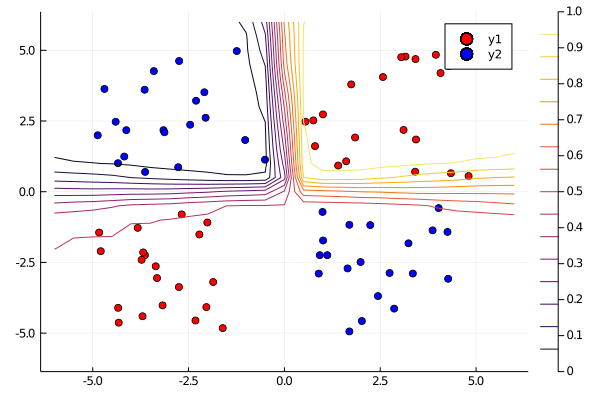

In [13]:
# Plot the average prediction.
plot_data()

n_end = 1500
x_range = collect(range(-6,stop=6,length=25))
y_range = collect(range(-6,stop=6,length=25))
Z = [nn_predict([x, y], theta, n_end)[1] for x=x_range, y=y_range]
contour!(x_range, y_range, Z)

This has been an introduction to the applications of Turing and Flux in defining Bayesian neural networks.